##### Scope

To forecast the first three days of February 2017 (72 hours) of electricity consumption for column "PowerConsumption_Zone1", using the entire month of January 2017, and fitting both a Linear Regression model and Facebook Prophet.

#### Data load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

electricity_df = pd.read_csv(
    "../Data/powerconsumption.csv", 
    index_col=["Datetime"],
    parse_dates=["Datetime"]
).resample("H").mean()

electricity_df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


<Axes: xlabel='Datetime'>

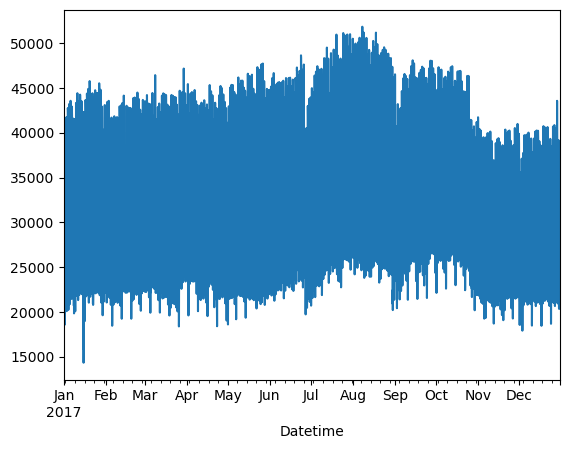

In [2]:
electricity_df['PowerConsumption_Zone1'].plot()

### 1. Exploration

#### 1.1. Exploring rolling averages vs. electricy consumption

In [3]:
electricity_explore = electricity_df[['Temperature','WindSpeed', 'Humidity','PowerConsumption_Zone1']]

In [4]:
electricity_explore = electricity_explore.assign(
                                        power_weekly = electricity_explore["PowerConsumption_Zone1"].rolling(window=(7*24)).mean(),
                                        power_monthly = electricity_explore["PowerConsumption_Zone1"].rolling(window=(30*24)).mean(),
                                        power_quarterly = electricity_explore["PowerConsumption_Zone1"].rolling(window=(3*30*24)).mean()
                                    )

In [5]:
electricity_explore = electricity_explore.assign(
                                        temp_weekly = electricity_explore["Temperature"].rolling(window=(7*24)).mean(),
                                        temp_monthly = electricity_explore["Temperature"].rolling(window=(30*24)).mean(),
                                        temp_quarterly = electricity_explore["Temperature"].rolling(window=(3*30*24)).mean()
                                    )

In [6]:
electricity_explore = electricity_explore.assign(
                                        wind_weekly = electricity_explore["WindSpeed"].rolling(window=(7*24)).mean(),
                                        wind_monthly = electricity_explore["WindSpeed"].rolling(window=(30*24)).mean(),
                                        wind_quarterly = electricity_explore["WindSpeed"].rolling(window=(3*30*24)).mean()
                                    )

In [7]:
electricity_explore = electricity_explore.assign(
                                        humidity_weekly = electricity_explore["Humidity"].rolling(window=(7*24)).mean(),
                                        humidity_monthly = electricity_explore["Humidity"].rolling(window=(30*24)).mean(),
                                        humidity_quarterly = electricity_explore["Humidity"].rolling(window=(3*30*24)).mean()
                                    )

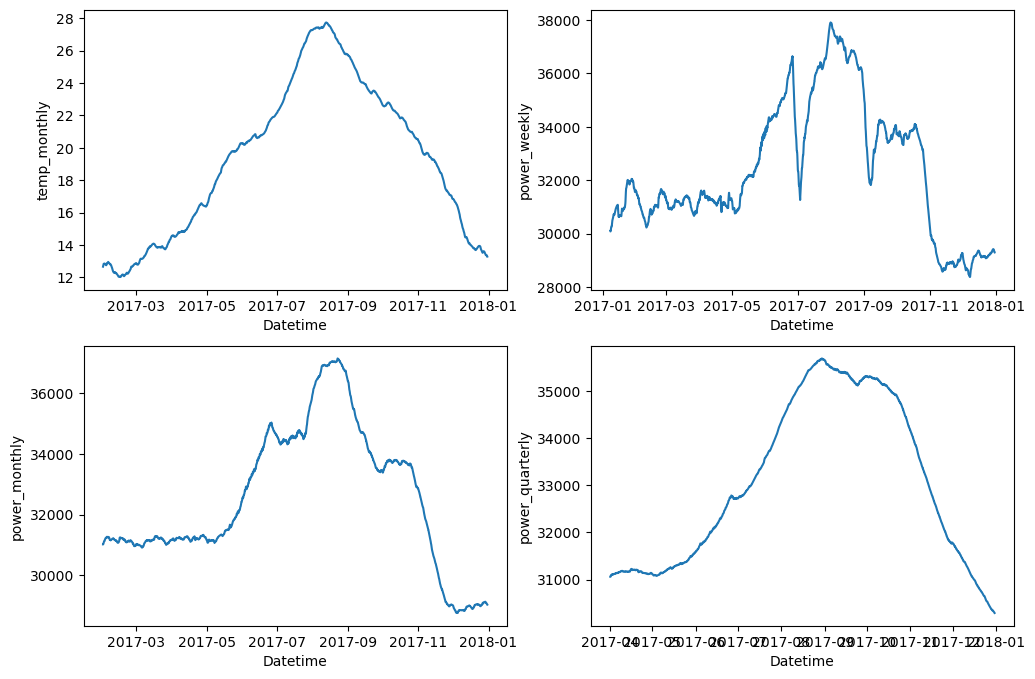

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


sns.lineplot(data=electricity_explore, x="Datetime", y="temp_monthly", ax=axs[0,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_weekly", ax=axs[0,1]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_monthly", ax=axs[1,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_quarterly", ax=axs[1,1]);


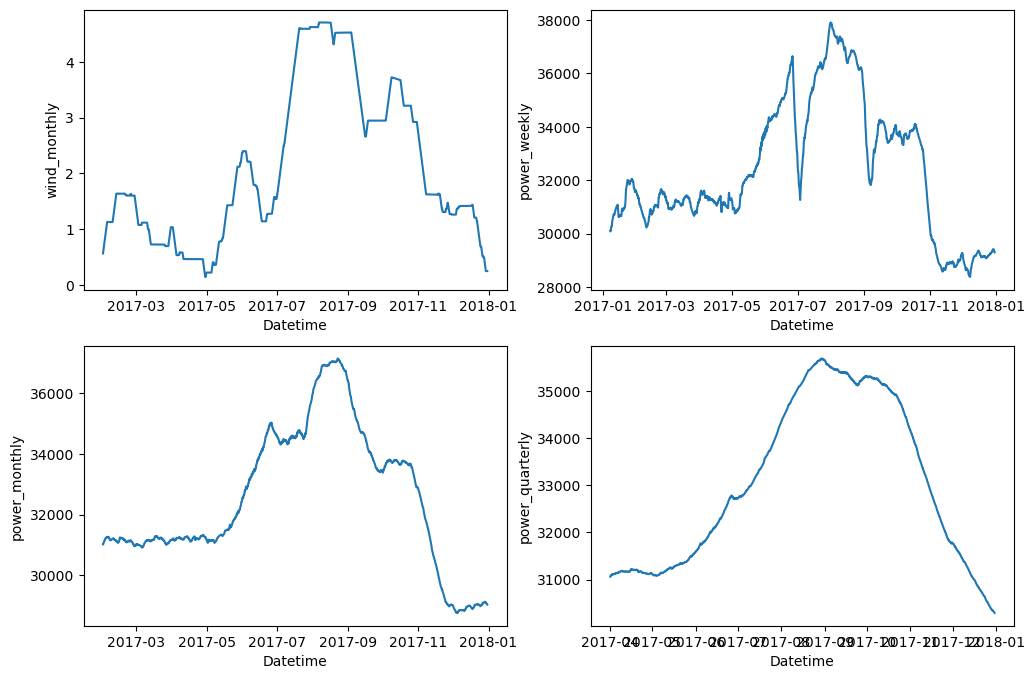

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


sns.lineplot(data=electricity_explore, x="Datetime", y="wind_monthly", ax=axs[0,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_weekly", ax=axs[0,1]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_monthly", ax=axs[1,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_quarterly", ax=axs[1,1]);


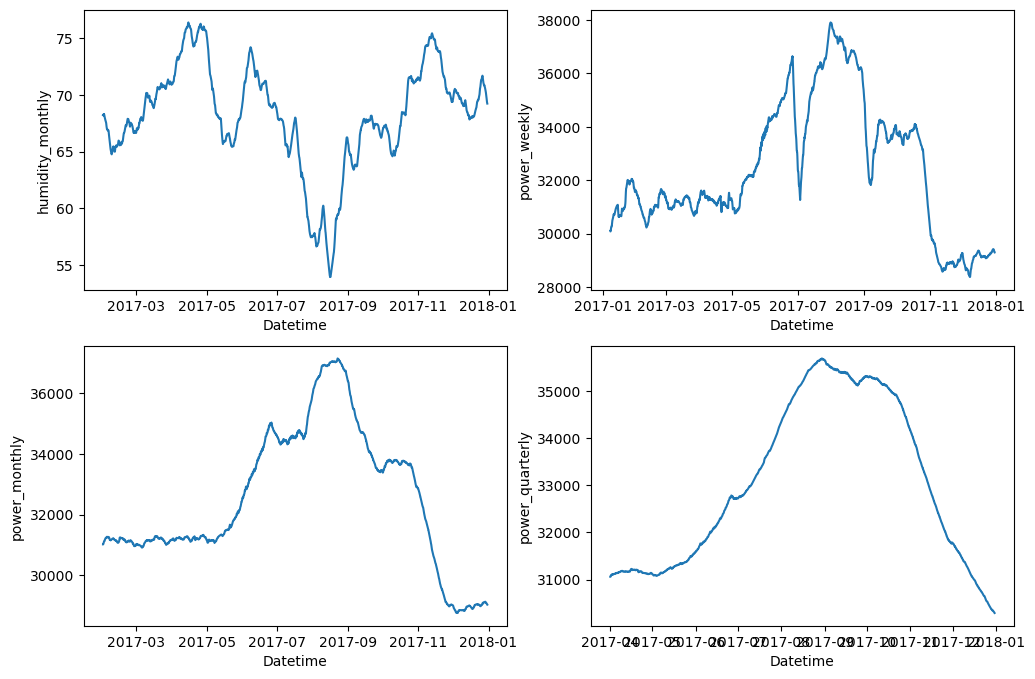

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


sns.lineplot(data=electricity_explore, x="Datetime", y="humidity_monthly", ax=axs[0,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_weekly", ax=axs[0,1]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_monthly", ax=axs[1,0]);
sns.lineplot(data=electricity_explore, x="Datetime", y="power_quarterly", ax=axs[1,1]);


##### Commentary

There seems to be a correlation between wind and temperature values and the PowerConsumption_Zone1.

#### 1.2. Autocorrelations

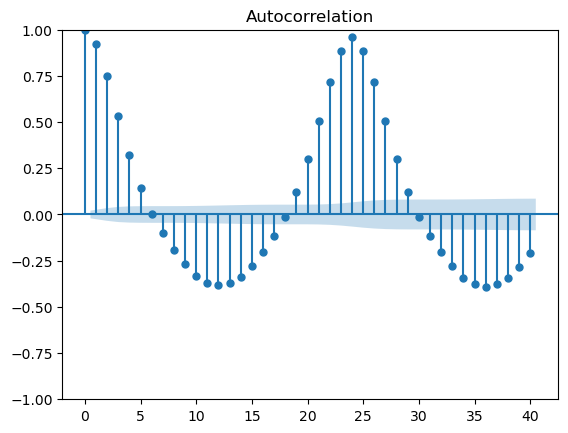

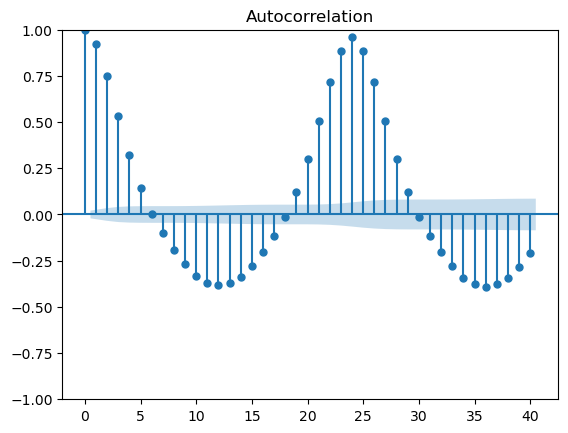

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(electricity_explore['PowerConsumption_Zone1'].values.squeeze())

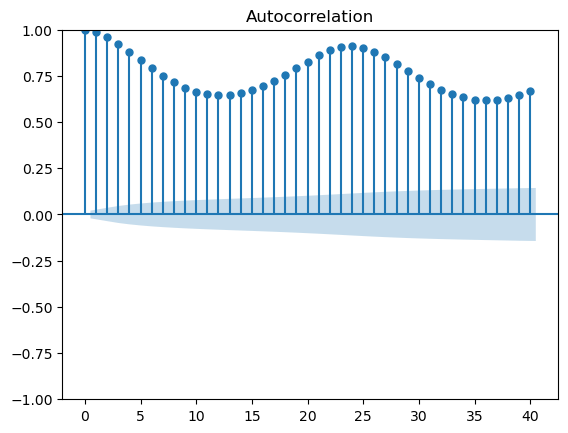

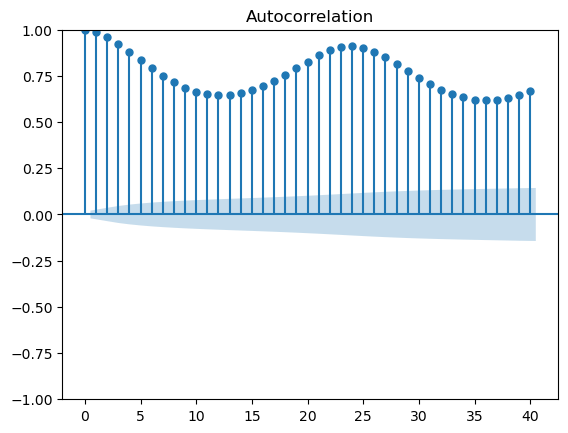

In [40]:
plot_acf(electricity_explore['Temperature'].values.squeeze())

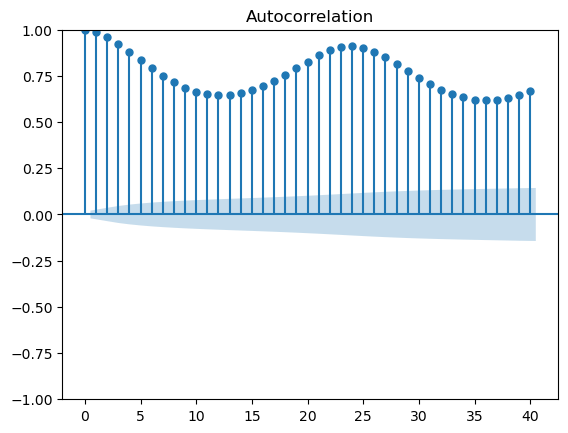

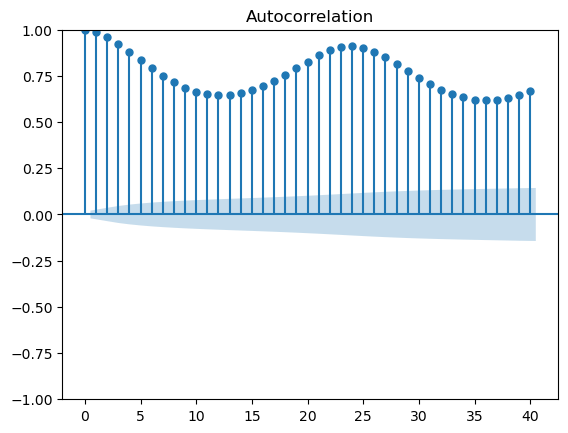

In [43]:
plot_acf(electricity_explore['Temperature'].values.squeeze())

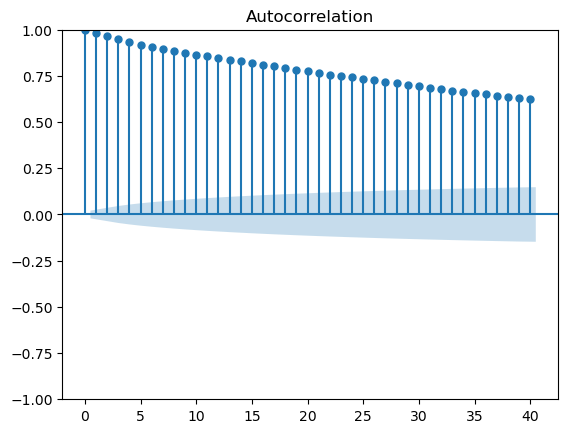

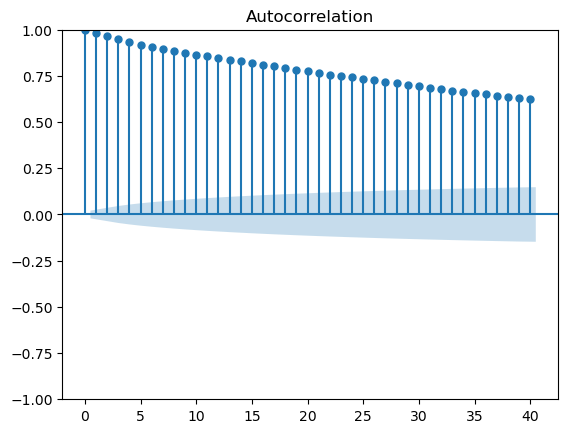

In [48]:
plot_acf(electricity_explore['WindSpeed'].values.squeeze())

#### 1.3. Decompositions

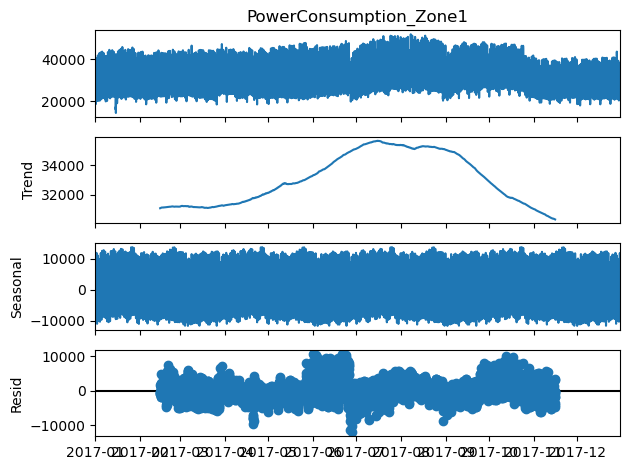

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(electricity_explore['PowerConsumption_Zone1'], model='additive', period=(24*30*3)).plot();

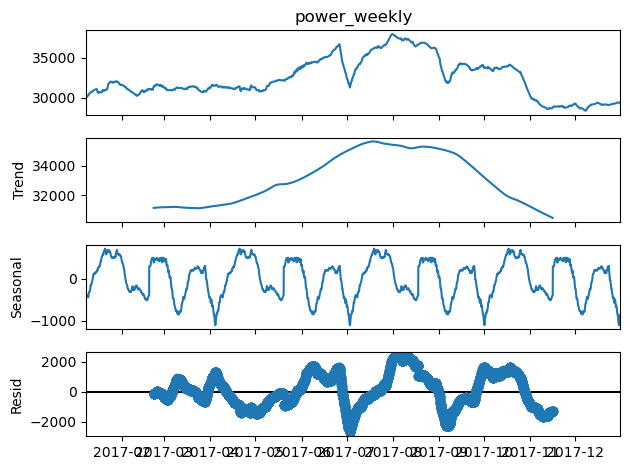

In [31]:
seasonal_decompose(electricity_explore['power_weekly'][(24*7):], model='additive', period=(24*30*3)).plot();

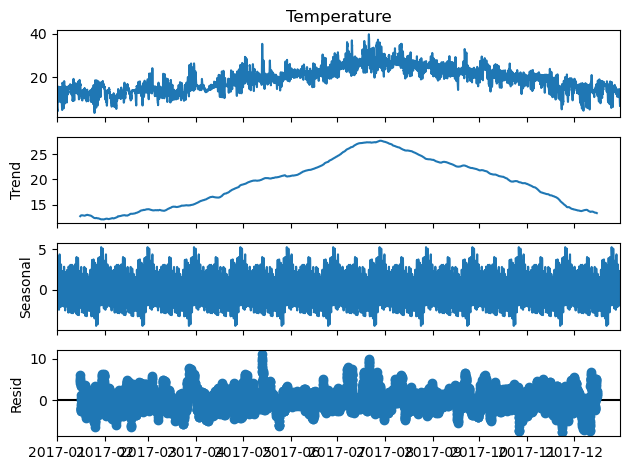

In [25]:
seasonal_decompose(electricity_explore['Temperature'], model='additive', period=(24*30)).plot();

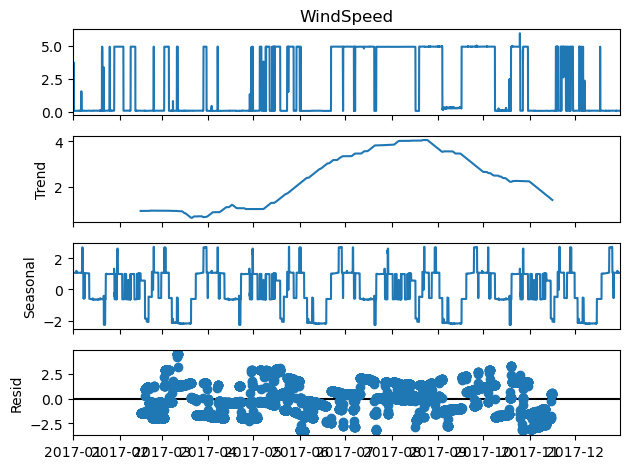

In [34]:
seasonal_decompose(electricity_explore['WindSpeed'], model='additive', period=(24*30*3)).plot();

#### Commentary

There seems to be a correlation between wind and temperature values and the PowerConsumption_Zone1. The decompositions suggest that there might be a connection between first peak of power consumption at around July and Temparature, and between second peak in power consumption at around September and WindSpeed.

## 2. Linear Regression

Forecasting the first three days of February 2017 (72 hours) of electricity consumption for column PowerConsumption_Zone1, using the entire month of January 2017 to train your Model.

#### 2.1. Loading data

In [78]:
electricity_df = pd.read_csv(
    "../Data/powerconsumption.csv",
    usecols=["PowerConsumption_Zone1", "Datetime"],
    index_col=["Datetime"],
    parse_dates=["Datetime"]
).resample("H").mean().reset_index()

electricity_df.tail()

,Datetime,PowerConsumption_Zone1
8731,2017-12-30 19:00:00,37513.814957
8732,2017-12-30 20:00:00,37008.871988
8733,2017-12-30 21:00:00,35358.174905
8734,2017-12-30 22:00:00,33993.409380
8735,2017-12-30 23:00:00,30107.984788


In [79]:
electricity_df = electricity_df[electricity_df['Datetime'] < '2017-02-04']

#### 2.2. Creating features

In [80]:
electricity_df = (electricity_df.assign(hour_var = lambda x: x['Datetime'].dt.hour.astype('string'),
                                        trend = electricity_df.index))

In [83]:
hours_dummies = pd.get_dummies(electricity_df['hour_var'], drop_first=True, dtype=int)
electricity_df = electricity_df.merge(hours_dummies, how='left', left_index=True, right_index=True)

#### 2.3. Splitting data

In [85]:
electricity_df_train = electricity_df[electricity_df['Datetime'] < '2017-02-01']
electricity_df_test = electricity_df[electricity_df['Datetime'] >= '2017-02-01']

#### 2.4. Fitting the model

In [88]:
# Model Fitting
import statsmodels.api as sm

features = [str(i) for i in range(1,24)]
features.append('trend')

y = electricity_df['PowerConsumption_Zone1']
X = sm.add_constant(electricity_df[features])

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     PowerConsumption_Zone1   R-squared:                       0.952
Model:                                OLS   Adj. R-squared:                  0.950
Method:                     Least Squares   F-statistic:                     647.1
Date:                    Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                            15:25:26   Log-Likelihood:                -7180.7
No. Observations:                     816   AIC:                         1.441e+04
Df Residuals:                         791   BIC:                         1.453e+04
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.654e+04    295.623     89.781      0.000     2.6e+04    2.71e+04
1          -3345.2716    395.421     -8.460      0.000   -4121.471   -2569.072
2          -5003.1817    395.422    -12.653      0.000   -5779.381   -4226.982
3          -5811.5586    395.422    -14.697      0.000   -6587.759   -5035.358
4          -6074.3830    395.422    -15.362      0.000   -6850.584   -5298.182
5          -5372.6735    395.423    -13.587      0.000   -6148.876   -4596.471
6          -3522.7806    395.424     -8.909      0.000   -4298.985   -2746.576
7          -4847.5529    395.425    -12.259      0.000   -5623.759   -4071.347
8          -3138.0850    395.426     -7.936      0.000   -3914.293   -2361.877
9            318.5541    395.427      0.806      0.421    -457.657    1094.765
10          3634.5479    395.429      9.191      0.000    2858.334    4410.761
11          5898.5786    395.430     14.917      0.000    5122.362    6674.795
12          6674.1260    395.432     16.878      0.000    5897.906    7450.346
13          6822.1395    395.434     17.252      0.000    6045.916    7598.363
14          6123.8651    395.436     15.486      0.000    5347.637    6900.093
15          5514.9431    395.438     13.946      0.000    4738.711    6291.175
16          4994.1978    395.440     12.629      0.000    4217.961    5770.434
17          8662.4942    395.443     21.906      0.000    7886.253    9438.735
18          1.555e+04    395.445     39.335      0.000    1.48e+04    1.63e+04
19          1.553e+04    395.448     39.284      0.000    1.48e+04    1.63e+04
20          1.528e+04    395.451     38.640      0.000    1.45e+04    1.61e+04
21          1.354e+04    395.454     34.245      0.000    1.28e+04    1.43e+04
22          1.007e+04    395.457     25.457      0.000    9290.838    1.08e+04
23          4781.0090    395.461     12.090      0.000    4004.733    5557.285
trend          2.2630      0.242      9.336      0.000       1.787       2.739
==============================================================================
Omnibus:                      301.206   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1502.486
Skew:                          -1.620   Prob(JB):                         0.00
Kurtosis:                       8.805   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2.5. Building predictions

In [89]:
y_test = electricity_df_test['PowerConsumption_Zone1']
X_test = electricity_df_test[features]

prediction = model.predict(sm.add_constant(X_test))

In [90]:
predictions = pd.DataFrame({'Actuals': y_test, 'Predicted': prediction})

#### 2.6. Checking forecast accuracy



In [92]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

print(mape(predictions['Actuals'], predictions['Predicted']))
print(mae(predictions['Actuals'], predictions['Predicted']))

0.028609041423357295
880.6245857021541


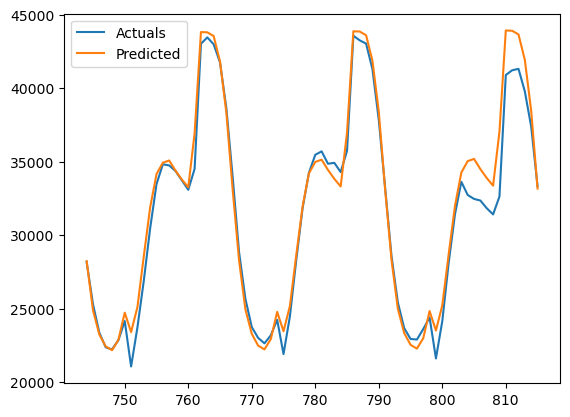

In [93]:
predictions.plot();

## 3. Facebook Prophet

#### 3.1. Loading data

In [94]:
from prophet import Prophet

In [95]:
electricity_df = pd.read_csv(
    "../Data/powerconsumption.csv",
    usecols=["PowerConsumption_Zone1", "Datetime"],
    index_col=["Datetime"],
    parse_dates=["Datetime"]
).resample("H").mean().reset_index()

electricity_df = electricity_df[electricity_df['Datetime'] < '2017-02-04']

#### 3.2. Renaming the columns to fit the model reqs

In [96]:
electricity_df = electricity_df.rename(columns={'Datetime': 'ds', 'PowerConsumption_Zone1': 'y'})

#### 3.3. Splitting data

In [98]:
electricity_df_train = electricity_df[electricity_df['ds'] < '2017-02-01']
electricity_df_test = electricity_df[electricity_df['ds'] >= '2017-02-01']

#### 3.4. Fitting Prophet model

In [99]:
prophet_model = Prophet()
prophet_model.fit(electricity_df_train)

15:39:59 - cmdstanpy - INFO - Chain [1] start processing
15:39:59 - cmdstanpy - INFO - Chain [1] done processing


#### 3.5. Building predictions


C:\Users\jpopl\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\jpopl\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


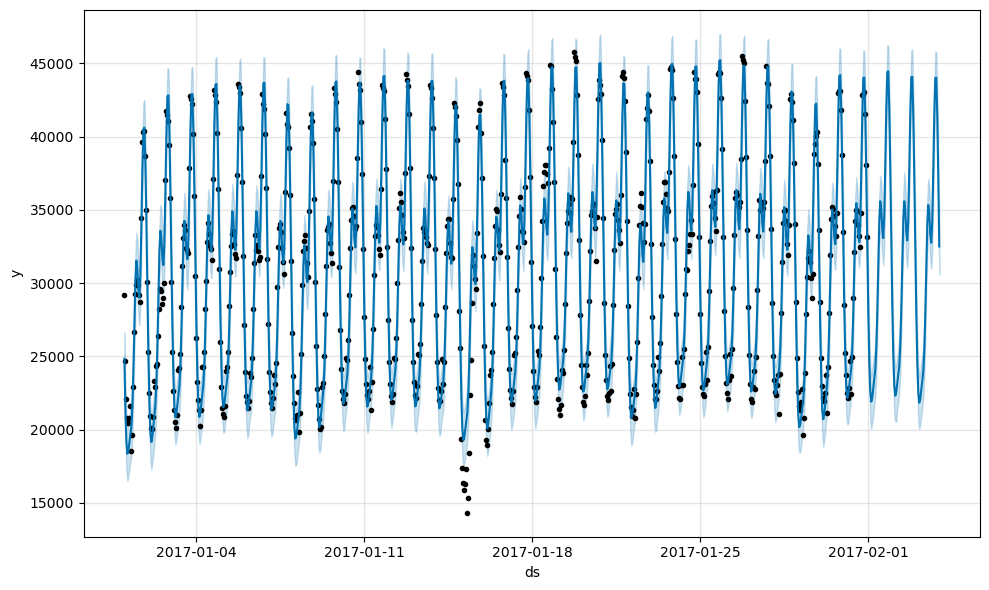

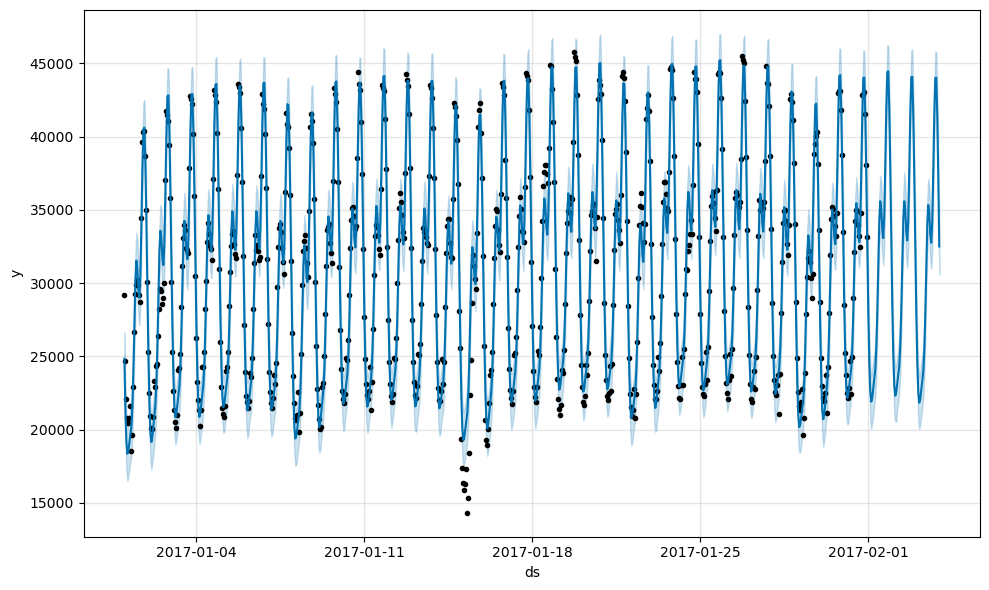

In [107]:
prophet_predict = prophet_model.make_future_dataframe(periods=72, freq='H')
prophet_predictions = prophet_model.predict(prophet_predict)
prophet_model.plot(prophet_predictions)

#### 3.6. Decomposition of the model

C:\Users\jpopl\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\jpopl\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\jpopl\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of 

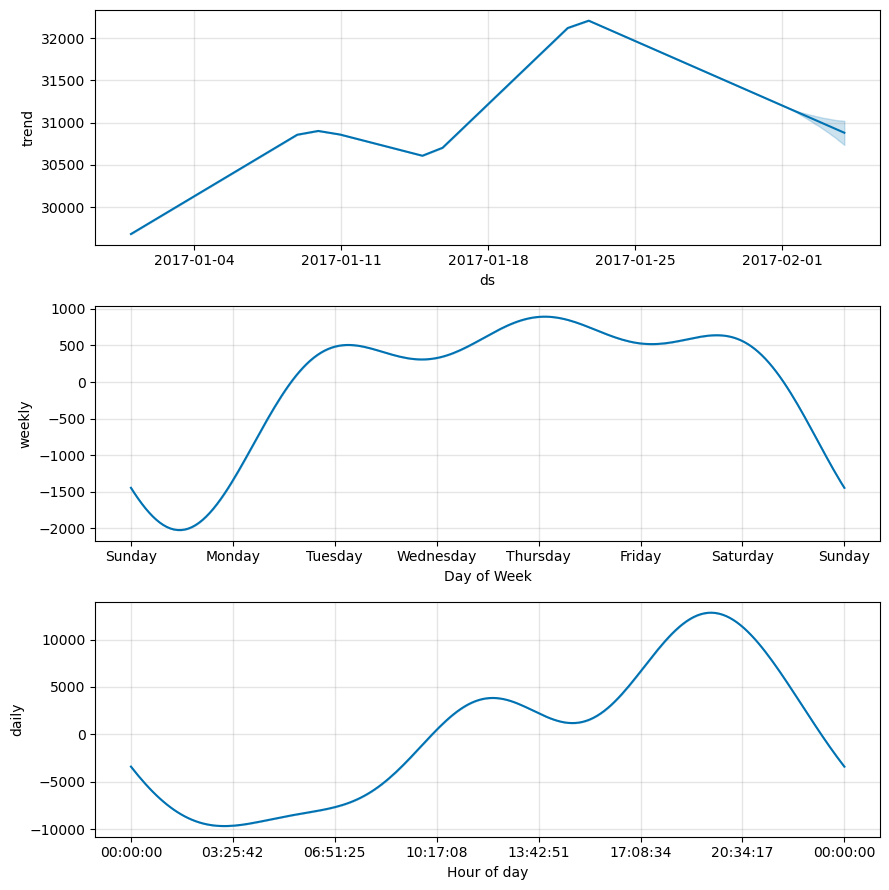

In [108]:
fig = prophet_model.plot_components(prophet_predictions)

#### 3.7. Forecast accuracy

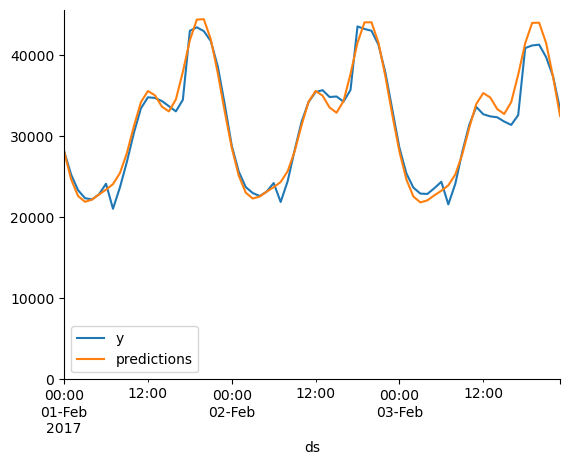

In [109]:
import seaborn as sns

electricity_df_test.assign(predictions = prophet_model.predict(prophet_predict)['yhat']).set_index('ds').plot(ylim=0);

sns.despine();

In [110]:
future = prophet_predictions[prophet_predictions['ds'] >= '2017-02-01']

In [114]:
future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
744,2017-02-01 00:00:00,31203.409814,26053.341420,29923.974791,31203.409814,31203.409814,-3065.914895,-3065.914895,-3065.914895,-3394.232599,-3394.232599,-3394.232599,328.317704,328.317704,328.317704,0.0,0.0,0.0,28137.494919
745,2017-02-01 01:00:00,31198.862259,22948.047605,26560.640701,31198.862259,31198.862259,-6494.113899,-6494.113899,-6494.113899,-6835.237990,-6835.237990,-6835.237990,341.124091,341.124091,341.124091,0.0,0.0,0.0,24704.748360
746,2017-02-01 02:00:00,31194.314704,20703.293844,24369.505604,31194.314704,31194.314704,-8568.110544,-8568.110544,-8568.110544,-8925.129982,-8925.129982,-8925.129982,357.019438,357.019438,357.019438,0.0,0.0,0.0,22626.204160
747,2017-02-01 03:00:00,31189.767149,20047.550064,23656.360788,31189.767149,31189.767149,-9273.428198,-9273.428198,-9273.428198,-9649.279312,-9649.279312,-9649.279312,375.851114,375.851114,375.851114,0.0,0.0,0.0,21916.338951
748,2017-02-01 04:00:00,31185.219594,20523.052364,24202.125680,31185.219594,31185.219594,-8996.450488,-8996.450488,-8996.450488,-9393.870427,-9393.870427,-9393.870427,397.419939,397.419939,397.419939,0.0,0.0,0.0,22188.769106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2017-02-03 19:00:00,30898.723624,42064.975887,45806.303548,30769.730970,31026.713774,13107.802089,13107.802089,13107.802089,12470.097209,12470.097209,12470.097209,637.704880,637.704880,637.704880,0.0,0.0,0.0,44006.525713
812,2017-02-03 20:00:00,30894.176069,42279.119359,45764.112462,30761.386706,31024.949323,13135.356891,13135.356891,13135.356891,12503.589050,12503.589050,12503.589050,631.767841,631.767841,631.767841,0.0,0.0,0.0,44029.532960
813,2017-02-03 21:00:00,30889.628514,39648.507347,43310.245226,30752.698727,31024.365181,10627.813983,10627.813983,10627.813983,10006.381445,10006.381445,10006.381445,621.432538,621.432538,621.432538,0.0,0.0,0.0,41517.442496
814,2017-02-03 22:00:00,30885.080959,35490.692637,39113.549826,30743.969392,31023.518339,6422.574125,6422.574125,6422.574125,5816.277763,5816.277763,5816.277763,606.296361,606.296361,606.296361,0.0,0.0,0.0,37307.655083


In [115]:
print(f"MAPE: {mape(electricity_df_test['y'], future['yhat'])}")
print(f"MAE: {mae(electricity_df_test['y'], future['yhat'])}")

MAPE: 0.03450125754742524
MAE: 1048.7549824889622
